# EBM Training on Google Colab Pro+ (A100)

This notebook trains an Energy-Based Model (EBM) to learn the energy landscape of UC/DR/Storage binary variables from MILP solutions, conditioned on Hierarchical Temporal Encoder embeddings.

## Hardware Requirements
- **GPU**: A100 (40 or 80 GB VRAM)
- **RAM**: 50+ GB (High RAM runtime)
- **Storage**: 100+ GB on Drive

## Setup
1. Upload your `benchmark` repo to Google Drive
2. Select Runtime → Change runtime type → A100 GPU + High RAM
3. Run cells in order

---

## 1. Mount Google Drive and Setup Paths

In [1]:
# Mount Google Drive
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# Set paths - ADJUST THIS to match your Drive structure
REPO_PATH = '/content/drive/MyDrive/benchmark'
EMBEDDING_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_flat.pt'
SCENARIOS_DIR = 'outputs/scenarios_v1'
OUTPUT_DIR = 'outputs/ebm_models'

# Add repo to Python path
sys.path.insert(0, REPO_PATH)

# Verify paths exist
print(f"Repo path: {REPO_PATH}")
print(f"Repo exists: {os.path.exists(REPO_PATH)}")
print(f"Embeddings path: {os.path.join(REPO_PATH, EMBEDDING_FILE)}")
print(f"Embeddings exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_FILE))}")
print(f"Scenarios exist: {os.path.exists(os.path.join(REPO_PATH, SCENARIOS_DIR))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repo path: /content/drive/MyDrive/benchmark
Repo exists: True
Embeddings path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_flat.pt
Embeddings exist: True
Scenarios exist: True


## 2. Install Dependencies

In [5]:
# Install required packages
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install -q wandb tqdm pandas numpy scipy

import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q wandb numpy scipy tqdm pandas thrml

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: torch_scatter 2.1.2+pt25cu124
Uninstalling torch_scatter-2.1.2+pt25cu124:
  Successfully uninstalled torch_scatter-2.1.2+pt25cu124
Found existing installation: torch_sparse 0.6.18+pt25cu124
Uninstalling torch_sparse-0.6.18+pt25cu124:
  Successfully uninstalled torch_sparse-0.6.18+pt25cu124
Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 16.8 MB/s eta 0:00:00
   

## 3. Check GPU and System Info

In [2]:
import torch
import subprocess

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)

# GPU Info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

    # Verify it's A100
    if 'A100' in gpu_name:
        print("✓ A100 GPU detected!")
    else:
        print(f"⚠️  Warning: Expected A100, got {gpu_name}")
        print("   Change runtime: Runtime → Change runtime type → A100")
else:
    print("❌ No GPU detected!")
    print("   Enable GPU: Runtime → Change runtime type → GPU")

# RAM Info
try:
    mem_info = !cat /proc/meminfo | grep MemTotal
    mem_gb = int(mem_info[0].split()[1]) / 1e6
    print(f"\nRAM: {mem_gb:.1f} GB")
    if mem_gb > 45:
        print("✓ High RAM runtime detected!")
    else:
        print("⚠️  Consider using High RAM runtime for better performance")
except:
    print("\nCouldn't detect RAM")

# Disk Space
disk_info = !df -h /content
print(f"\nDisk Space:\n{disk_info[1]}")

print("=" * 60)

SYSTEM INFORMATION
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB
CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
✓ A100 GPU detected!

RAM: 175.2 GB
✓ High RAM runtime detected!

Disk Space:
overlay         236G   47G  190G  20% /


## 4. Import EBM Modules

In [3]:
import os

os.chdir(REPO_PATH)

from torch.utils.data import DataLoader, random_split, Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_add_pool
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime

from src.ebm import (
    EnergyModel,
    StructuredEnergyModel,
    GibbsSampler,
    SGLDSampler,
    # PersistentContrastiveDivergence, # Removed due to ImportError
    MILPBinaryDataset,
    EBMTrainer,
    # ScheduledEBMTrainer,
    EBMMetrics,
    # TemporalMetrics,
    EmbeddingLoader,
    # collate_ebm_batch,
)

from src.ebm.model import GraphEnergyModel
from src.ebm.sampler import PersistentContrastiveDivergence, GraphSampler
from src.ebm.dataset import collate_ebm_batch, GraphBinaryDataset
from src.ebm.trainer import EBMTrainer, ScheduledEBMTrainer
from src.ebm.metrics import TemporalMetrics

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 5. Configuration

In [4]:
# Training Configuration
import shutil

# Define paths
drive_embedding_path = os.path.join(REPO_PATH, EMBEDDING_FILE)
local_embedding_path = '/content/embeddings_flat.pt'

# Copy file if not present locally
if not os.path.exists(local_embedding_path):
    print(f"🔄 Copying embeddings to local disk for faster I/O...")
    print(f"   Source: {drive_embedding_path}")
    print(f"   Dest:   {local_embedding_path}")
    print("   ⏳ This may take 1 minute...")
    shutil.copy(drive_embedding_path, local_embedding_path)
    print("   ✓ Copy complete!")
else:
    print(f"✓ Embeddings already found locally: {local_embedding_path}")

CONFIG = {
    # Data
    'scenarios_dir': os.path.join(REPO_PATH, SCENARIOS_DIR),
    'embedding_file': local_embedding_path, # Updated to local path
    'output_dir': os.path.join(REPO_PATH, OUTPUT_DIR),

    # Model
    'model_type': 'structured',  # 'basic', 'structured', or 'factorized'
    'hidden_dims': [256, 256, 64],
    'use_quadratic': True,
    'quadratic_rank': 16,
    'activation': 'gelu',
    'dropout': 0.1,

    # Data loading
    'embedding_loading_mode': 'full',  # 'full' or 'lazy' - use full on A100!
    'temporal': False,  # Set True for temporal EBM
    'temporal_aggregation': 'mean',  # 'mean', 'max', 'last', 'first'

    # Training
    'batch_size': 128,  # Large batches for A100
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'gradient_clip': 1.0,

    # Sampling
    'sampler_type': 'pcd',  # 'gibbs', 'sgld', or 'pcd'
    'num_gibbs_steps': 5,  # Reduced from 50 to 5 for PCD (10x speedup)
    'temperature': 1.0,
    'initial_temperature': 2.0,
    'final_temperature': 1.0,
    'use_pcd': True,
    'num_pcd_chains': 128, # Reduced from 2000 to 128 to fix latency bottleneck

    # Training dynamics
    'num_negative_samples': 1,
    'use_amp': True,  # Mixed precision for A100
    'num_workers': 0,  # Parallel data loading

    # Evaluation
    'validate_every': 5,
    'save_every': 10,

    # Logging
    'use_wandb': False,  # Set True to log to W&B
    'wandb_project': 'milp-ebm',
    'wandb_name': f'ebm_a100_{datetime.now().strftime("%Y%m%d_%H%M%S")}',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

# Set random seed
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Print configuration
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for key, value in CONFIG.items():
    if not key.startswith('_'):
        print(f"{key:25s}: {value}")
print("=" * 60 + "\n")

🔄 Copying embeddings to local disk for faster I/O...
   Source: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_flat.pt
   Dest:   /content/embeddings_flat.pt
   ⏳ This may take 8 minutes...
   ✓ Copy complete!

TRAINING CONFIGURATION
scenarios_dir            : /content/drive/MyDrive/benchmark/outputs/scenarios_v1
embedding_file           : /content/embeddings_flat.pt
output_dir               : /content/drive/MyDrive/benchmark/outputs/ebm_models
model_type               : structured
hidden_dims              : [256, 256, 64]
use_quadratic            : True
quadratic_rank           : 16
activation               : gelu
dropout                  : 0.1
embedding_loading_mode   : full
temporal                 : False
temporal_aggregation     : mean
batch_size               : 128
num_epochs               : 100
learning_rate            : 0.0001
weight_decay             : 1e-05
gradient_clip            : 1.0
sampler_type             : pcd
num_gibbs_steps       

## 6. Load Dataset with Full Embeddings

In [5]:
# Clear RAM
import gc
gc.collect()

# Define dummy class to handle legacy pickle data
class TrainingConfig:
    pass

print("Loading dataset...")
print(f"Embedding loading mode: {CONFIG['embedding_loading_mode']}")
print("⏳ This may take 1 minutes for full loading...\n")

dataset = MILPBinaryDataset(
    scenarios_dir=CONFIG['scenarios_dir'],
    embedding_file=CONFIG['embedding_file'],
    embedding_loading_mode=CONFIG['embedding_loading_mode'],
    temporal=CONFIG['temporal'],
    temporal_aggregation=CONFIG['temporal_aggregation'],
    device='cpu',  # Keep on CPU, move to GPU in batches
)

# --- FILTER DATASET TO MATCH EMBEDDINGS ---
if hasattr(dataset, 'embedding_loader') and hasattr(dataset.embedding_loader, 'keys'):
    valid_keys = set(dataset.embedding_loader.keys)
    print(f"\n🔍 Found {len(valid_keys)} embeddings in file.")

    if len(valid_keys) > 0 and len(valid_keys) < len(dataset):
        print(f"⚠️ Dataset has {len(dataset)} scenarios, but only {len(valid_keys)} embeddings found.")
        print("🧹 Filtering dataset to match available embeddings...")

        # Filter scenarios (handling potential filename extensions)
        valid_scenarios = []
        for s in dataset.scenarios:
            # key might be the filename or filename without extension
            key = os.path.splitext(s)[0]
            if key in valid_keys or s in valid_keys:
                valid_scenarios.append(s)

        dataset.scenarios = valid_scenarios
        print(f"✓ Filtered down to {len(dataset)} scenarios.")
    elif len(valid_keys) == 0:
        print("❌ No embeddings found in loader keys! Check the file structure.")
    else:
        print("✓ All scenarios have embeddings.")
else:
    print("⚠️ Could not check embedding keys (loader might not expose them).")
# ------------------------------------------

print(f"\n✓ Dataset loaded: {len(dataset)} scenarios")

if len(dataset) > 0:
    # Get sample to determine dimensions
    sample = dataset[0]
    dim_u = sample['u'].shape[0]
    dim_h = sample['h'].shape[0]

    print(f"Binary dimension (dim_u): {dim_u}")
    print(f"Embedding dimension (dim_h): {dim_h}")
    print(f"Sample scenario: {sample['scenario_id']}")
    print(f"Binary vars shape: {sample['u'].shape}")
    print(f"Embedding shape: {sample['h'].shape}")

    # Check if embeddings are real (not random)
    h_mean = sample['h'].mean().item()
    h_std = sample['h'].std().item()
    print(f"\nEmbedding stats: mean={h_mean:.4f}, std={h_std:.4f}")
    if abs(h_mean) < 0.1 and abs(h_std - 1.0) < 0.2:
        print("⚠️  Warning: Embeddings look like random noise!")
    else:
        print("✓ Real embeddings detected")
else:
    print("❌ Dataset is empty after filtering!")

Loading dataset...
Embedding loading mode: full
⏳ This may take 4 minutes for full loading...


Initializing embedding loader from: /content/embeddings_flat.pt
Found embeddings at: /content/embeddings_flat.pt
Initializing EmbeddingLoader for /content/embeddings_flat.pt
File size: 0.10 GB
Loading mode: full
Loading full embeddings file (this may take a while)...
Loaded direct mapping with 2000 scenarios
Sample embedding shape: torch.Size([96, 128])
Sample embedding dtype: torch.float32
Total scenarios: 2000
Embeddings already on CPU
Embedding loader initialized with 2000 scenarios


/content/drive/MyDrive/benchmark/src/ebm/embedding_loader.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.embedding_file, map_location=self.devic

Loaded 2000 scenarios from /content/drive/MyDrive/benchmark/outputs/scenarios_v1
Binary variables per scenario: 9600
Timesteps: 96
⚠️ Could not check embedding keys (loader might not expose them).

✓ Dataset loaded: 2000 scenarios
Binary dimension (dim_u): 59808
Embedding dimension (dim_h): 128
Sample scenario: scenario_00001
Binary vars shape: torch.Size([59808])
Embedding shape: torch.Size([128])

Embedding stats: mean=0.0385, std=1.3715
✓ Real embeddings detected


In [6]:
# Instantiate the wrapper using the existing dataset
# (Assuming 'dataset' variable exists from previous steps)
print("Wrapping existing dataset with GraphBinaryDataset...")
graph_dataset = GraphBinaryDataset(dataset)
print(f"✓ Wrapped {len(graph_dataset)} samples")

# Verify first sample
sample0 = graph_dataset[0]
print("\nFirst sample verification:")
print(f"Type: {type(sample0)}")
print(f"x shape: {sample0.x.shape}")
print(f"h shape: {sample0.h.shape}")
if hasattr(sample0, 'scenario_id'):
    print(f"Scenario: {sample0.scenario_id}")

Wrapping existing dataset with GraphBinaryDataset...
✓ Wrapped 2000 samples

First sample verification:
Type: <class 'torch_geometric.data.data.Data'>
x shape: torch.Size([59808, 1])
h shape: torch.Size([1, 128])
Scenario: scenario_00001


## 7. Create Train/Val Split and DataLoaders

In [7]:
# Split dataset
train_size = int(0.8 * len(graph_dataset))
val_size = len(graph_dataset) - train_size
train_dataset, val_dataset = random_split(graph_dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Create Geometric DataLoaders
# These loaders automatically handle the creation of 'Batch' objects for variable-sized graphs
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verify a batch structure
print("Verifying batch structure, this may take 5 minutes...")
try:
    batch = next(iter(train_loader))
    print("\nBatch verification:")
    print(f"Batch type: {type(batch)}")
    print(f"x shape: {batch.x.shape} (Total nodes in batch)")
    print(f"h shape: {batch.h.shape} (Batch size x Embed dim)")
    print(f"batch index shape: {batch.batch.shape}")
    print(f"Num graphs: {batch.num_graphs}")
except Exception as e:
    print(f"\nError fetching batch: {e}")

Train samples: 1600
Val samples: 400
Train batches: 13
Val batches: 4

Batch verification:
Batch type: <class 'abc.DataBatch'>
x shape: torch.Size([4455360, 1]) (Total nodes in batch)
h shape: torch.Size([128, 128]) (Batch size x Embed dim)
batch index shape: torch.Size([4455360])
Num graphs: 128


## 8. Initialize Model

In [8]:
# Instantiate the model
print("Initializing GraphEnergyModel...")
graph_model = GraphEnergyModel(
    dim_u=1,  # Binary variable is a scalar
    dim_h=CONFIG['embedding_file'].endswith('flat.pt') and 128 or 128, # assuming 128 from previous context
    hidden_dims=CONFIG['hidden_dims'],
    activation=CONFIG['activation'],
    dropout=CONFIG['dropout']
)

graph_model = graph_model.to(CONFIG['device'])

# Print model details
num_params = sum(p.numel() for p in graph_model.parameters())
print(f"Model architecture:\n{graph_model}")
print(f"\nTotal parameters: {num_params:,}")
print("\u2713 Graph Energy Model initialized")

Initializing GraphEnergyModel...
Model architecture:
GraphEnergyModel(
  (mlp): Sequential(
    (0): Linear(in_features=129, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 115,585
✓ Graph Energy Model initialized


## 9. Initialize Sampler

In [9]:
print("Initializing GraphSampler...")
graph_sampler = GraphSampler(graph_model, device=CONFIG['device'])
print("\u2713 Graph Sampler initialized")

Initializing GraphSampler...
✓ Graph Sampler initialized


## 10. Training Loop with Monitoring

In [10]:
# Optimizer
optimizer = optim.AdamW(
    graph_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Training settings
num_epochs = CONFIG['num_epochs']
device = CONFIG['device']
validate_every = CONFIG['validate_every']
output_dir = CONFIG['output_dir']

print(f"Starting Graph EBM training for {num_epochs} epochs on {device}...")

history = {
    'train_loss': [], 'val_loss': [],
    'train_gap': [], 'val_gap': [],
    'train_e_pos': [], 'train_e_neg': []
}

best_val_gap = -float('inf')

for epoch in range(1, num_epochs + 1):
    graph_model.train()
    total_loss = 0
    total_gap = 0

    # NEW: accumulators for energy stats
    total_e_pos = 0
    total_e_neg = 0
    count_batches = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for batch in pbar:
        batch = batch.to(device)

        # --- Positive Phase ---
        e_pos = graph_model(batch)          # shape: (batch_size,)

        # --- Negative Phase ---
        u_neg = graph_sampler.sample(batch) # same shape as batch.x

        batch_neg = batch.clone()
        batch_neg.x = u_neg

        e_neg = graph_model(batch_neg)

        # --- Loss ---
        energy_gap = e_pos.mean() - e_neg.mean()
        reg_loss = 0.01 * (e_pos.pow(2).mean() + e_neg.pow(2).mean())
        loss = energy_gap + reg_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(graph_model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Accumulate
        total_loss += loss.item()
        total_gap += energy_gap.item()
        total_e_pos += e_pos.mean().item()
        total_e_neg += e_neg.mean().item()
        count_batches += 1

        pbar.set_postfix({
            'gap': energy_gap.item(),
            'loss': loss.item()
        })

    # Epoch metrics
    avg_loss = total_loss / count_batches
    avg_gap = total_gap / count_batches
    avg_e_pos = total_e_pos / count_batches
    avg_e_neg = total_e_neg / count_batches

    history['train_loss'].append(avg_loss)
    history['train_gap'].append(avg_gap)
    history['train_e_pos'].append(avg_e_pos)
    history['train_e_neg'].append(avg_e_neg)

    # PRINT EXTENDED DEBUG INFO
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Gap: {avg_gap:.4f} | "
          f"E_pos: {avg_e_pos:.4f} | E_neg: {avg_e_neg:.4f}")

    # --- Validation ---
    if epoch % validate_every == 0:
        graph_model.eval()
        val_gap_sum = 0
        val_e_pos_sum = 0
        val_e_neg_sum = 0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                e_pos = graph_model(batch)
                u_neg = graph_sampler.sample(batch)

                batch_neg = batch.clone()
                batch_neg.x = u_neg
                e_neg = graph_model(batch_neg)

                val_gap_sum += (e_pos.mean() - e_neg.mean()).item()
                val_e_pos_sum += e_pos.mean().item()
                val_e_neg_sum += e_neg.mean().item()
                val_batches += 1

        avg_val_gap = val_gap_sum / val_batches
        avg_val_e_pos = val_e_pos_sum / val_batches
        avg_val_e_neg = val_e_neg_sum / val_batches

        history['val_gap'].append(avg_val_gap)

        print(f"  └ Validation | Gap: {avg_val_gap:.4f} | "
              f"E_pos: {avg_val_e_pos:.4f} | E_neg: {avg_val_e_neg:.4f}")

        # Save best
        if avg_val_gap > best_val_gap:
            best_val_gap = avg_val_gap
            torch.save(graph_model.state_dict(), os.path.join(output_dir, 'graph_ebm_best.pt'))
            print("  ✓ New best model saved!")

# Save final model
torch.save(graph_model.state_dict(), os.path.join(output_dir, 'graph_ebm_final.pt'))
print("✓ Training complete. Models saved.")


Starting Graph EBM training for 100 epochs on cuda...


Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11. Plot Training Curves

KeyError: 'train_energy_gap'

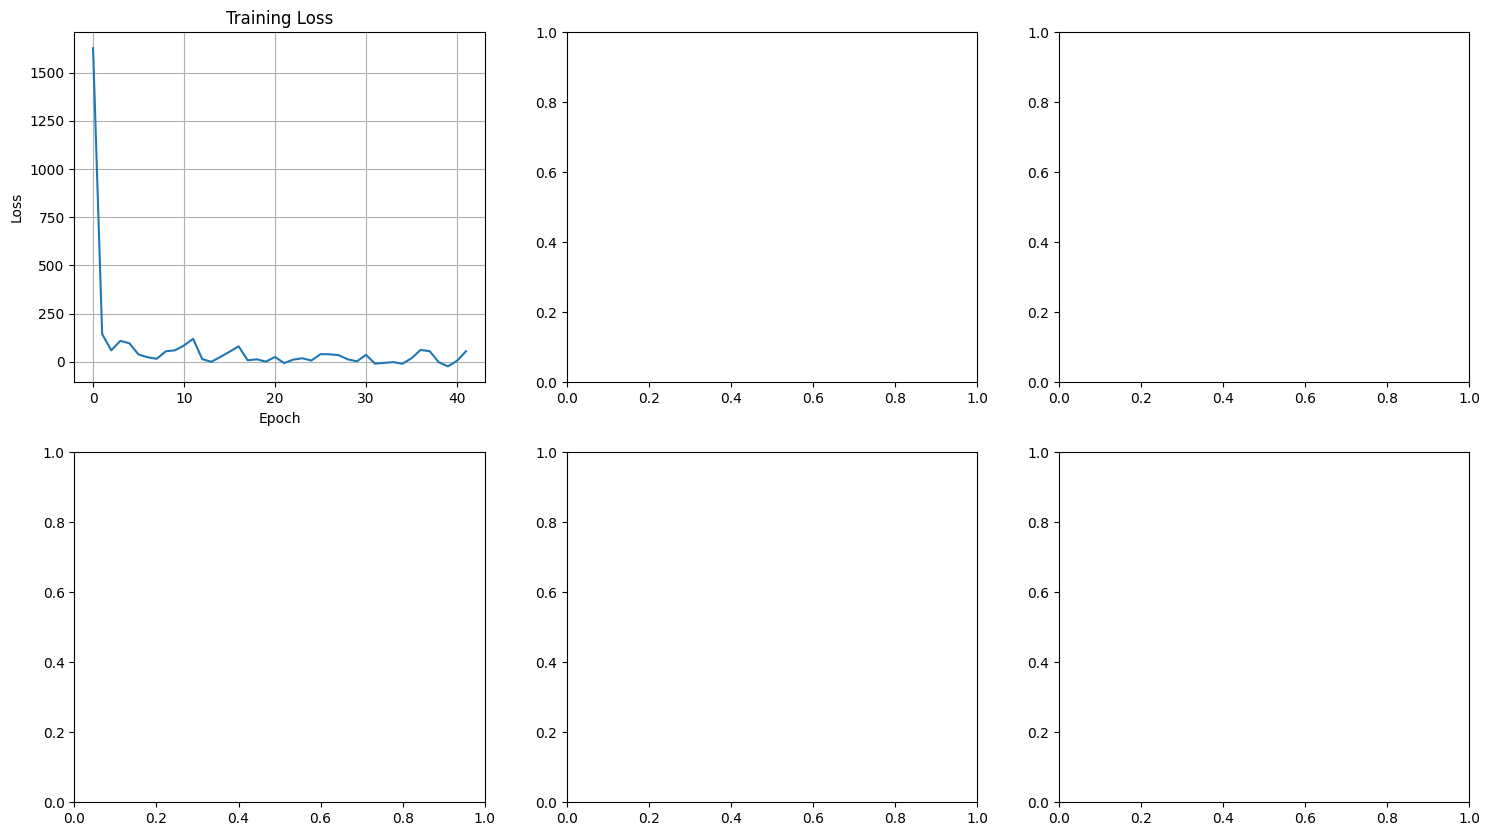

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
if len(history.get('val_loss', [])) > 0:
    val_epochs = [i * CONFIG['validate_every'] for i in range(len(history['val_loss']))]
    axes[0, 0].plot(val_epochs, history['val_loss'], label='Val', marker='o', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Energy gap (E_pos - E_neg)
axes[0, 1].plot(history['train_gap'], label='Train', linewidth=2, color='green')
if len(history.get('val_gap', [])) > 0:
    val_epochs = [i * CONFIG['validate_every'] for i in range(len(history['val_gap']))]
    axes[0, 1].plot(val_epochs, history['val_gap'], label='Val', marker='o', linewidth=2, color='darkgreen')
axes[0, 1].set_title('Energy Gap (E_pos - E_neg)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Gap', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Positive energy
axes[1, 0].plot(history['train_e_pos'], linewidth=2, color='blue')
axes[1, 0].set_title('Positive Sample Energy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('E(u_pos | graph)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Negative energy
axes[1, 1].plot(history['train_e_neg'], linewidth=2, color='red')
axes[1, 1].set_title('Negative Sample Energy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('E(u_neg | graph)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png')}")

## 12. Save Training History

In [ ]:
import json

# Save history as JSON
history_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_training_history.json')

with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to {history_path}")

# Save config
config_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_config.json')
with open(config_path, 'w') as f:
    # Convert non-serializable types
    config_save = {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v 
                   for k, v in CONFIG.items()}
    json.dump(config_save, f, indent=2)

print(f"✓ Config saved to {config_path}")

# Print summary statistics
print("\n" + "=" * 60)
print("TRAINING STATISTICS")
print("=" * 60)
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Best validation gap: {max(history.get('val_gap', [0])):.4f}")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final training gap: {history['train_gap'][-1]:.4f}")
print("=" * 60)

✓ Training history saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/training_history.json
✓ Config saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/config.json


## 13. Evaluate Best Model

In [ ]:
print("Evaluating best Graph EBM model...\n")

# Load best checkpoint
best_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_best.pt')
if os.path.exists(best_path):
    graph_model.load_state_dict(torch.load(best_path))
    print(f"✓ Loaded best model from {best_path}")
else:
    print(f"⚠️  Best model not found, using current model")

# Detailed validation
graph_model.eval()

all_energy_pos = []
all_energy_neg = []
all_gaps = []
all_graph_sizes = []

print("Running evaluation on validation set...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = batch.to(CONFIG['device'])
        
        # Positive energy (ground truth)
        E_pos = graph_model(batch)
        
        # Sample negatives
        u_neg = graph_sampler.sample(batch)
        batch_neg = batch.clone()
        batch_neg.x = u_neg
        E_neg = graph_model(batch_neg)
        
        # Compute metrics
        energy_gap = (E_pos.mean() - E_neg.mean()).item()
        
        # Store results
        all_energy_pos.append(E_pos.mean().item())
        all_energy_neg.append(E_neg.mean().item())
        all_gaps.append(energy_gap)
        
        # Track graph sizes for analysis
        batch_size = batch.h.shape[0]
        avg_nodes = batch.x.shape[0] / batch_size
        all_graph_sizes.append(avg_nodes)

# Summary statistics
print("\n" + "=" * 60)
print("EVALUATION RESULTS (GRAPH EBM)")
print("=" * 60)
print(f"Energy (positive):    {np.mean(all_energy_pos):.4f} ± {np.std(all_energy_pos):.4f}")
print(f"Energy (negative):    {np.mean(all_energy_neg):.4f} ± {np.std(all_energy_neg):.4f}")
print(f"Energy gap:           {np.mean(all_gaps):.4f} ± {np.std(all_gaps):.4f}")
print(f"\nGraph Statistics:")
print(f"  Avg nodes per graph: {np.mean(all_graph_sizes):.1f}")
print(f"  Total batches:       {len(all_gaps)}")
print("=" * 60)

# Save evaluation results
eval_results = {
    'energy_pos_mean': float(np.mean(all_energy_pos)),
    'energy_pos_std': float(np.std(all_energy_pos)),
    'energy_neg_mean': float(np.mean(all_energy_neg)),
    'energy_neg_std': float(np.std(all_energy_neg)),
    'energy_gap_mean': float(np.mean(all_gaps)),
    'energy_gap_std': float(np.std(all_gaps)),
    'avg_graph_size': float(np.mean(all_graph_sizes)),
    'num_batches': len(all_gaps),
}

eval_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_evaluation_results.json')
with open(eval_path, 'w') as f:
    json.dump(eval_results, f, indent=2)

print(f"\n✓ Evaluation results saved to {eval_path}")

## 14. Sample and Analyze Configurations

In [ ]:
print("Sampling configurations from Graph EBM...\n")

# Get a test graph from validation set
test_batch = next(iter(val_loader)).to(CONFIG['device'])
print(f"Test batch size: {test_batch.h.shape[0]} graphs")
print(f"Total nodes: {test_batch.x.shape[0]}")
print(f"Nodes per graph (avg): {test_batch.x.shape[0] / test_batch.h.shape[0]:.1f}")

# Sample multiple configurations for the same graph
num_samples = 10
print(f"\nGenerating {num_samples} samples...")

sampled_energies = []
sampled_configs = []

with torch.no_grad():
    # Get ground truth energy
    E_true = graph_model(test_batch)
    print(f"Ground truth energy: {E_true.mean().item():.4f}")
    
    # Sample multiple configurations
    for i in range(num_samples):
        u_sample = graph_sampler.sample(test_batch)
        batch_sample = test_batch.clone()
        batch_sample.x = u_sample
        E_sample = graph_model(batch_sample)
        
        sampled_energies.append(E_sample.mean().item())
        sampled_configs.append(u_sample.cpu().numpy())

# Analyze samples
print(f"\n{num_samples} samples generated:")
print(f"Energy range: [{min(sampled_energies):.4f}, {max(sampled_energies):.4f}]")
print(f"Energy mean: {np.mean(sampled_energies):.4f}")
print(f"Energy std: {np.std(sampled_energies):.4f}")

# Check diversity (average Hamming distance between samples)
if num_samples > 1:
    hamming_distances = []
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dist = np.mean(sampled_configs[i] != sampled_configs[j])
            hamming_distances.append(dist)
    
    avg_diversity = np.mean(hamming_distances)
    print(f"\nSample diversity (avg Hamming): {avg_diversity:.4f}")

# Visualize first sample
sample_u = sampled_configs[0].flatten()
plt.figure(figsize=(15, 4))

# Plot first 500 variables or all if less
n_plot = min(500, len(sample_u))
plt.subplot(1, 2, 1)
plt.plot(sample_u[:n_plot], 'o-', markersize=2, linewidth=0.5)
plt.title(f'Sample Binary Configuration (first {n_plot} variables)', fontsize=12, fontweight='bold')
plt.xlabel('Variable Index')
plt.ylabel('Value')
plt.ylim([-0.1, 1.1])
plt.grid(True, alpha=0.3)

# Plot histogram of values
plt.subplot(1, 2, 2)
unique, counts = np.unique(sample_u, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Binary Values', fontsize=12, fontweight='bold')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add sparsity info
sparsity = np.mean(sample_u == 0)
plt.text(0.5, max(counts)*0.9, f'Sparsity: {sparsity:.1%}', 
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Sample visualization saved")
print(f"\nSample statistics:")
print(f"  Total variables: {len(sample_u)}")
print(f"  Sparsity (% zeros): {sparsity:.1%}")
print(f"  Active variables: {np.sum(sample_u == 1)}")

## 15. Summary and Next Steps

In [ ]:
# Count model parameters
num_params = sum(p.numel() for p in graph_model.parameters())
num_trainable = sum(p.numel() for p in graph_model.parameters() if p.requires_grad)

# Get dataset info
try:
    dataset_size = len(train_loader.dataset) + len(val_loader.dataset)
except:
    dataset_size = "Unknown"

print("\n" + "=" * 60)
print("GRAPH EBM TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel Architecture:")
print(f"  Model Type: Graph Energy Model (Deep Sets)")
print(f"  Parameters: {num_params:,}")
print(f"  Trainable: {num_trainable:,}")
print(f"  Hidden Dims: {CONFIG['hidden_dims']}")
print(f"  Activation: {CONFIG['activation']}")
print(f"  Dropout: {CONFIG['dropout']}")

print(f"\nTraining Configuration:")
print(f"  Epochs: {len(history['train_loss'])}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Dataset size: {dataset_size}")
print(f"  Device: {CONFIG['device']}")

print(f"\nTraining Results:")
print(f"  Best validation gap: {max(history.get('val_gap', [0])):.4f}")
print(f"  Final training loss: {history['train_loss'][-1]:.4f}")
print(f"  Final training gap: {history['train_gap'][-1]:.4f}")
print(f"  Final E_pos: {history['train_e_pos'][-1]:.4f}")
print(f"  Final E_neg: {history['train_e_neg'][-1]:.4f}")

if 'energy_gap_mean' in eval_results:
    print(f"\nEvaluation Metrics:")
    print(f"  Energy gap (mean): {eval_results['energy_gap_mean']:.4f} ± {eval_results['energy_gap_std']:.4f}")
    print(f"  Avg graph size: {eval_results['avg_graph_size']:.1f} nodes")

print(f"\nSaved Artifacts:")
print(f"  Best model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_best.pt')}")
print(f"  Final model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_final.pt')}")
print(f"  Training history: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_history.json')}")
print(f"  Evaluation results: {os.path.join(CONFIG['output_dir'], 'graph_ebm_evaluation_results.json')}")
print(f"  Training curves: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png')}")
print(f"  Sample visualization: {os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png')}")

print(f"\nNext Steps:")
print(f"  1. Analyze training curves and energy gaps")
print(f"  2. Test on different graph sizes and scenarios")
print(f"  3. Compare with flat EBM baseline")
print(f"  4. Tune sampling strategy (exact vs approximate)")
print(f"  5. Use sampled configurations for MILP warmstart")
print(f"  6. Evaluate on unseen scenarios")

print("\n" + "=" * 60)
print("✓ GRAPH EBM TRAINING COMPLETE!")
print("=" * 60)

# Optional: Show model summary
print(f"\nModel Summary:")
print(graph_model)